In [1]:
import yfinance as yf

# Download stock data from Yahoo Finance
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']
spread = hmc_data - hymtf_data

# Slice the data into the formation period, This is the period we will use to form the historical distribution of pct_change
hmc_formation = hmc_data.loc['2011-01-01':'2016-01-01']
hymtf_formation = hymtf_data.loc['2011-01-01':'2016-01-01']
spread_formation = hmc_formation - hymtf_formation


# Slice the data into the testing period, This is the period we will use to test the strategy
hmc_testing = hmc_data.loc['2016-01-01':'2019-01-01']
hymtf_testing = hymtf_data.loc['2016-01-01':'2019-01-01']
spread_testing = hmc_testing - hymtf_testing

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


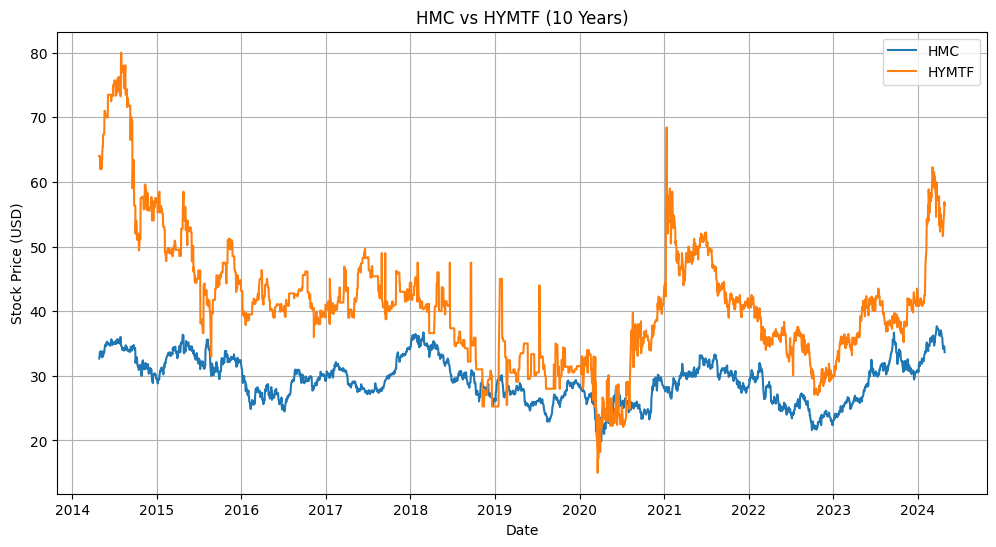

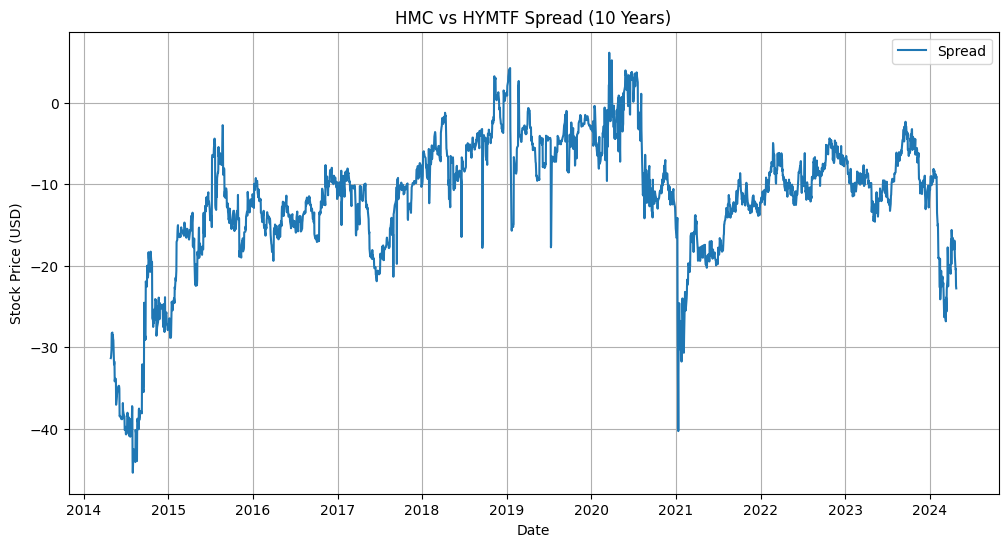

In [2]:
import matplotlib.pyplot as plt

# Plot the 'Close' data:
plt.figure(figsize=(12, 6))
plt.plot(hmc_data, label='HMC')
plt.plot(hymtf_data, label='HYMTF')
plt.title('HMC vs HYMTF (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the spread data:
plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread')
plt.title('HMC vs HYMTF Spread (10 Years)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

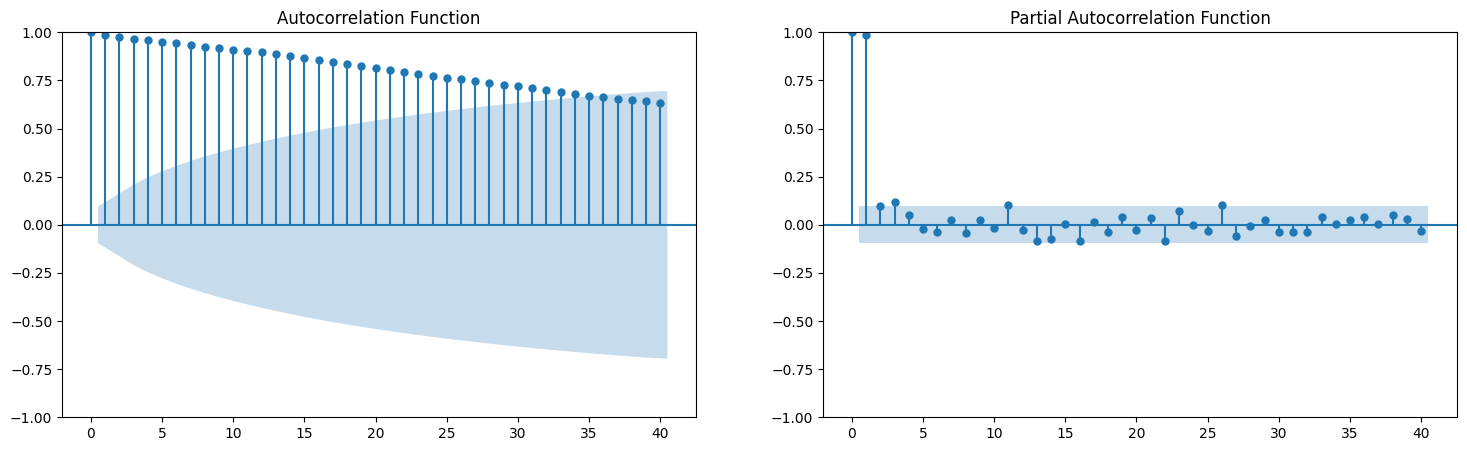

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(spread_series, lags=40):
    """
    Plot Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
    to help determine the order of AR and MA components in an ARMA model.

    Args:
    spread_series (pd.Series): The time series data of the spread between two stocks.
    lags (int): Number of lags to include in the plot.

    Returns:
    None: Displays the ACF and PACF plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Plot ACF
    plot_acf(spread_series, ax=axes[0], lags=lags)
    axes[0].set_title('Autocorrelation Function')

    # Plot PACF
    plot_pacf(spread_series, ax=axes[1], lags=lags)
    axes[1].set_title('Partial Autocorrelation Function')

    plt.show()

plot_acf_pacf(spread_formation, lags=40)

In [4]:
from pmdarima import auto_arima

def determine_arima_order(spread_series, seasonal=False, information_criterion='aic', trace=True):
    """
    Determines the optimal ARIMA order for a given time series.

    Parameters:
    spread_series (array-like): The time series data.
    seasonal (bool, optional): Whether the time series has a seasonal component. Default is False.
    information_criterion (str, optional): The information criterion used to select the best model. Default is 'aic'.

    Returns:
    best_fit (ARIMA model): The best-fit ARIMA model based on the selected order.

    """
    best_fit = auto_arima(spread_series, seasonal=seasonal, stepwise=True, trace=trace,
                          error_action='ignore', suppress_warnings=True, 
                          information_criterion=information_criterion)
    return best_fit

best_fit = determine_arima_order(spread_formation)  # Determine the optimal ARIMA order


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1578.899, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1591.022, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1587.937, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1585.844, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1589.409, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1582.326, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1581.530, Time=0.04 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1581.941, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1580.683, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1582.812, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1584.116, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1582.556, Time=0.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1581.754, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1577.384, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import pandas as pd
import warnings


def fit_arima_model(spread_series, order, hide_warnings=True):
    """
    Fit an ARIMA model to the provided time series data.

    Args:
    spread_series (pd.Series): The time series data of the spread between two stocks.
    order (tuple): The order (p, d, q) of the ARMA model.
    hide_warnings (bool): If True, suppress warnings from the ARIMA model.

    Returns:
    model_fit (ARIMAResultsWrapper): The fitted ARIMA model.
    """
    # Fit the ARIMA model
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = ARIMA(spread_series, order=(order[0], order[1], order[2]))
            model_fit = model.fit()
    else:
        model = ARIMA(spread_series, order=(order[0], order[1], order[2]))
        model_fit = model.fit()
    
    return model_fit

def model_diagnostics(model_fit, spread_testing=False, spread_testing_data=None, hide_warnings=True):
    """
    Perform diagnostics on the fitted model to check for any issues.

    Args:
    model_fit (ARIMAResultsWrapper): The fitted ARIMA model.
    spread_testing (bool): If True, perform testing on the spread.
    spread_testing_data (pd.Series): The testing data for the spread. Required if spread_testing is True.
    hide_warnings (bool): If True, suppress warnings from the ARIMA model.

    Returns:
    fig (Figure): Matplotlib figure object containing the diagnostics plots.
    """
    if spread_testing:
        if spread_testing_data is None:
            raise ValueError("spread_testing_data must be provided if spread_testing is True")
        predictions = forecast_spread(model_fit, steps=len(spread_testing_data), hide_warnings=hide_warnings)['mean']
        mse = root_mean_squared_error(spread_testing_data, predictions)
        mape = mean_absolute_percentage_error(spread_testing_data, predictions)
        print(f'Mean Squared Error: {mse:.2f}') 
        print(f'Mean Absolute Percentage Error: {mape:.2f}%')
    
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            fig = model_fit.plot_diagnostics(figsize=(12, 8))
    else:
        fig = model_fit.plot_diagnostics(figsize=(12, 8))
    plt.show()
    
    return fig

def forecast_spread(model_fit, steps=5, hide_warnings=True):
    """
    Forecast future values of the spread using the fitted ARIMA model.

    Args:
    model_fit (ARIMAResultsWrapper): The fitted ARMA model.
    steps (int): Number of future steps to forecast.

    Returns:
    forecast_result (pd.DataFrame): The forecasted values along with confidence intervals.
    """
    if hide_warnings:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            forecast_result = model_fit.get_forecast(steps=steps)
            forecast_df = forecast_result.summary_frame()
    else:
        forecast_result = model_fit.get_forecast(steps=steps)
        forecast_df = forecast_result.summary_frame()
    
    return forecast_df


## Spread Prediction Metrics

### Root Mean Squared Error
- Use to Mesaure the absolute accuracy of the models predictions
### Mean Absolute Precentage Error
- Use to compare the prediction accuracies on different spread data

## Model Diagnostics

### Standardized Residuals Over Time

This plot shows the residuals of the model over time. In a well-behaved model, we would expect the residuals to be randomly scattered around zero.

### Histogram plus Estimated Density

- This plot shows a histogram of the residuals along with the estimated density of the residuals.

- The orange line is the standard normal density

- Useful for checking if the residuals are normally distributed, which is one of the assumptions of an ARIMA model.

### Normal Q-Q Plot

Another way of checking if the residuals are normally distributed. If the residuals are normally distributed, the points in the Q-Q plot should lie along the red line.

### Correlelogram

- Shows the autocorrelation of the residuals. 

- In a well-behaved model, we would expect that there is little to no correlation between the residuals. 

- This means that the points in the correlogram should fall inside the blue area.




Mean Squared Error: 5.07
Mean Absolute Percentage Error: 1.11%


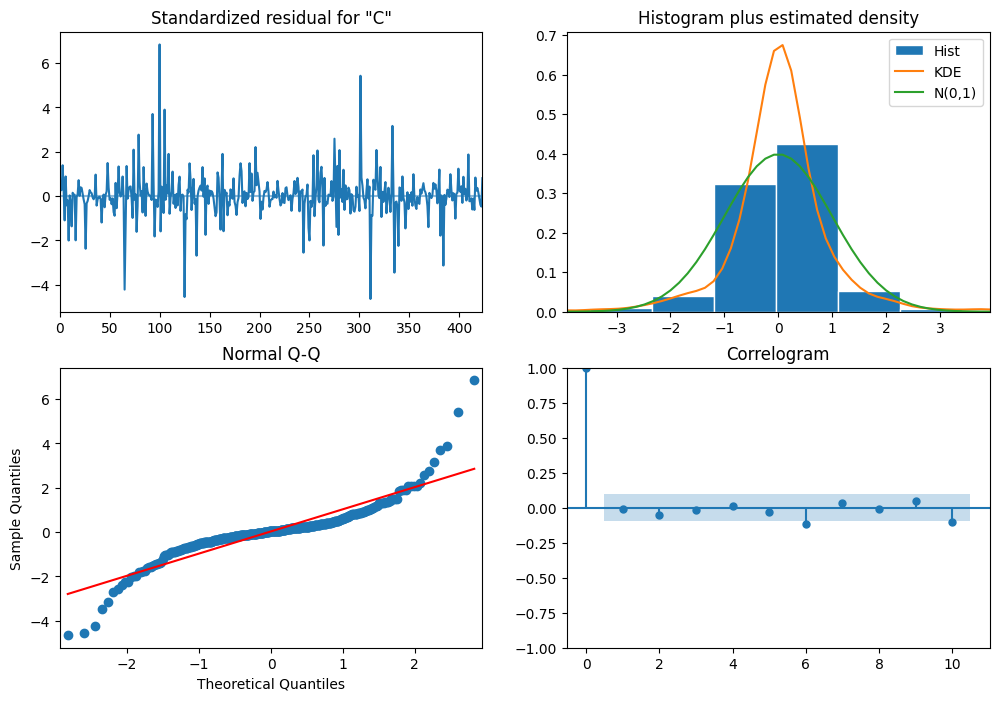

In [6]:
model_fit = fit_arima_model(spread_formation, best_fit.order)   # Fit the ARIMA model
diagnostics_fig = model_diagnostics(model_fit, spread_testing=True, spread_testing_data=spread_testing)  # Perform and show diagnostics on the fitted model
forecast_df = forecast_spread(model_fit, steps=10)  # Forecast future values of the spread
forecast_df.to_csv('forecast.csv')  # Save the forecasted values to a CSV file

In [9]:
# Import the packages needed for this task:
import yfinance as yf
import pandas as pd

# Download HMC and MYMTF price data:
hmc_data = yf.download('HMC', period='10y')['Close']
hymtf_data = yf.download('HYMTF', period='10y')['Close']

# Calculate the spread:
spread = hymtf_data - hmc_data

ROLLING_WINDOW = 8     # This is used for determining how many days ahead to use to calculate the rolling mean
TRAINING_PERIOD = 300   # This is the number of days to use for the training period

# Capital to allocate to each trade in the pairs trade:
money_per_trade = 50000

# Convert capital to shares:
hmc_share_quant = money_per_trade/hmc_data
hymtf_share_quant = money_per_trade/hymtf_data

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [10]:
daily_returns = []
trade_log = []
position_open = False
position_type = None
best_fit = determine_arima_order(spread, trace=False)
model_fit = fit_arima_model(spread.loc[:date], best_fit.order)

for date, current_spread in spread.items():
    if date not in hmc_data.index or date < spread.index[TRAINING_PERIOD]:
        continue

    # Determine the ARIMA order and fit the model using the training data up to the current date:
    date_range = date - pd.DateOffset(days=TRAINING_PERIOD)
    forecast_df = forecast_spread(model_fit, steps=ROLLING_WINDOW)
    # Calculate the rolling mean and bands bbased on foredasted spread
    rolling_mean = forecast_df['mean'].rolling(window=ROLLING_WINDOW).mean().dropna()
    rolling_std = forecast_df['mean'].rolling(window=ROLLING_WINDOW).std().dropna()
    upper_band = rolling_mean + (rolling_std * 0.8)
    lower_band = rolling_mean - (rolling_std * 0.8)

    upper_band_value = upper_band.iloc[0]
    lower_band_value = lower_band.iloc[0]
    mean_value = rolling_mean.iloc[0]
    hmc_price = hmc_data.get(date, None)
    hymtf_price = hymtf_data.get(date, None)
    hmc_shares = hmc_share_quant.get(date, None)
    hymtf_shares = hymtf_share_quant.get(date, None)
    if current_spread < lower_band_value and not position_open:
        # Open a pairs trade position (short HMC, long HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'lower'
        
    elif current_spread > upper_band_value and not position_open:
        # Open a different pairs trade position (long HMC, short HYMTF)
        trade_log.append({
            'Date': date,
            'Action': 'Open Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = True
        position_type = 'upper'
    
    elif current_spread > mean_value and position_open and position_type == 'lower':
        # Close position opened at lower band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'lower',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False
        
    elif current_spread < mean_value and position_open and position_type == 'upper':
        # Close position opened at upper band
        trade_log.append({
            'Date': date,
            'Action': 'Close Position',
            'Type': 'upper',
            'HMC_Shares': hmc_shares,
            'HYMTF_Shares': hymtf_shares,
            'HMC_Price': hmc_price,
            'HYMTF_Price': hymtf_price
        })
        position_open = False

# Save the trade log DataFrame to a csv file for a visual sanity check:
trade_log_df = pd.DataFrame(trade_log)
trade_log_df.to_csv('tradelog.csv')

In [11]:
# Iterate through rows in our trade log DataFrame and calcule the pnl:
total_return = 0
open_position = None
close_position_dates = []
close_position_returns = []
for index, trade in trade_log_df.iterrows():
    if trade['Action'] == 'Open Position':
        open_position = trade
    elif trade['Action'] == 'Close Position' and open_position is not None:
        close_position = trade
        close_position_dates.append(trade['Date'])
        if open_position['Type'] == 'lower':
            hmc_profit_loss = (open_position['HMC_Price'] - trade['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (trade['HYMTF_Price'] - open_position['HYMTF_Price']) * (open_position['HYMTF_Shares'])
        elif open_position['Type'] == 'upper':
            hmc_profit_loss = (trade['HMC_Price'] - open_position['HMC_Price']) * (open_position['HMC_Shares'])
            hymtf_profit_loss = (open_position['HYMTF_Price'] - trade['HYMTF_Price']) * (open_position['HYMTF_Shares'])

        total_profit_loss = hmc_profit_loss + hymtf_profit_loss
        total_return += total_profit_loss
        close_position_returns.append(total_profit_loss)

profit_loss_df = pd.DataFrame(close_position_returns, index=close_position_dates, columns=['Profit/Loss'])
profit_loss_df.to_csv('returns.csv')

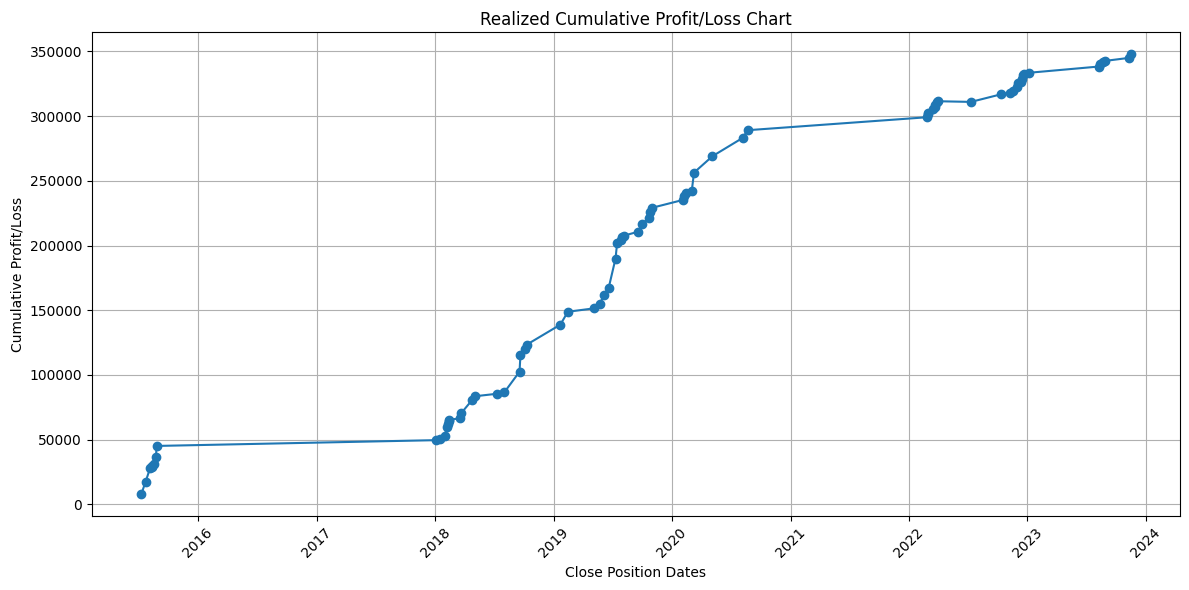

In [12]:
# Calculate the cumulative profit and loss:
profit_loss_df['Cumulative PnL'] = profit_loss_df['Profit/Loss'].cumsum()

# Plot:
plt.figure(figsize=(12, 6))
plt.plot(profit_loss_df.index, profit_loss_df['Cumulative PnL'], marker='o', linestyle='-')
plt.title('Realized Cumulative Profit/Loss Chart')
plt.xlabel('Close Position Dates')
plt.ylabel('Cumulative Profit/Loss')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()